# Note: This notebook is experimental and it should not be assumed that all methods used are correct or work perfectly

# Imports and Data Wrangling

In [ ]:
! pip install -q kaggle

### Upload your kaggle key

Instructions to get your key:
**Authentication**
In order to use the Kaggle’s public API, you must first authenticate using an API token. From the site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings at https://www.kaggle.com/account. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

In [ ]:
 from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d andrewmvd/covid19-ct-scans


 98% 1.01G/1.03G [00:07<00:00, 113MB/s]
100% 1.03G/1.03G [00:07<00:00, 153MB/s]


## Unzip the data

In [ ]:
! unzip covid19-ct-scans.zip

Archive:  covid19-ct-scans.zip
  inflating: ct_scans/coronacases_org_001.nii  
  inflating: ct_scans/coronacases_org_002.nii  
  inflating: ct_scans/coronacases_org_003.nii  
  inflating: ct_scans/coronacases_org_004.nii  
  inflating: ct_scans/coronacases_org_005.nii  
  inflating: ct_scans/coronacases_org_006.nii  
  inflating: ct_scans/coronacases_org_007.nii  
  inflating: ct_scans/coronacases_org_008.nii  
  inflating: ct_scans/coronacases_org_009.nii  
  inflating: ct_scans/coronacases_org_010.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii  
  inflating: ct_scans/radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii  
  inflating: ct_scans

In [ ]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Read and examine metadata
data = pd.read_csv('metadata.csv')
data['ct_scan'] = data['ct_scan'].str[26:]
data['lung_mask'] = data['lung_mask'].str[26:]
data['infection_mask'] = data['infection_mask'].str[26:]
data['lung_and_infection_mask'] = data['lung_and_infection_mask'].str[26:]

data.sample(2)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,ct_scans/coronacases_org_001.nii,lung_mask/coronacases_001.nii,infection_mask/coronacases_001.nii,lung_and_infection_mask/coronacases_001.nii
8,ct_scans/coronacases_org_009.nii,lung_mask/coronacases_009.nii,infection_mask/coronacases_009.nii,lung_and_infection_mask/coronacases_009.nii


In [ ]:
# ! mkdir input
# ! mkdir input/covid19-ct-scans

In [ ]:
# ! mv ct_scans/ lung_mask/ infection_mask/ lung_and_infection_mask/ input/covid19-ct-scans/ 

In [ ]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

# Sample Data

In [ ]:
# Read sample
sample_ct   = read_nii(data.loc[1,'ct_scan'])
sample_lung = read_nii(data.loc[1,'lung_mask'])
sample_infe = read_nii(data.loc[1,'infection_mask'])
sample_all  = read_nii(data.loc[1,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Lung and Infection Mask')

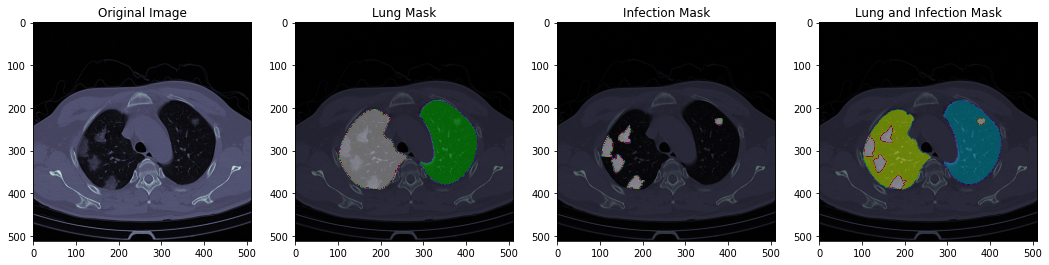

In [ ]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [ ]:
ct = read_nii(data['ct_scan'][0])
print(ct.shape)

(512, 512, 301)


In [ ]:
lungs = []
infections = []
groups = []
img_size = 256
import cv2
from tqdm import tqdm_notebook

total_count = 0
for i in tqdm_notebook(range(len(data))):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    init_count = total_count
    print(ct.shape)
    
    for ii in range(ct.shape[-1]):
        
        if ii==0:
            print(ct[..., ii].shape)
        
        lung_img = cv2.resize(ct[...,ii], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        infec_img = cv2.resize(infect[...,ii],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
#         lung_img = np.array(ct[...,ii])
#         infec_img = np.array(infect[...,ii])
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])
        groups.append(i)
        total_count += 1
    
    print(f"patient {i} ranges from {init_count} to {total_count-1}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


(512, 512, 301)
(512, 512)
patient 0 ranges from 0 to 300
(512, 512, 200)
(512, 512)
patient 1 ranges from 301 to 500
(512, 512, 200)
(512, 512)
patient 2 ranges from 501 to 700
(512, 512, 270)
(512, 512)
patient 3 ranges from 701 to 970
(512, 512, 290)
(512, 512)
patient 4 ranges from 971 to 1260
(512, 512, 213)
(512, 512)
patient 5 ranges from 1261 to 1473
(512, 512, 249)
(512, 512)
patient 6 ranges from 1474 to 1722
(512, 512, 301)
(512, 512)
patient 7 ranges from 1723 to 2023
(512, 512, 256)
(512, 512)
patient 8 ranges from 2024 to 2279
(512, 512, 301)
(512, 512)
patient 9 ranges from 2280 to 2580
(630, 630, 39)
(630, 630)
patient 10 ranges from 2581 to 2619
(630, 630, 418)
(630, 630)
patient 11 ranges from 2620 to 3037
(401, 630, 110)
(401, 630)
patient 12 ranges from 3038 to 3147
(630, 630, 66)
(630, 630)
patient 13 ranges from 3148 to 3213
(630, 630, 42)
(630, 630)
patient 14 ranges from 3214 to 3255
(630, 630, 42)
(630, 630)
patient 15 ranges from 3256 to 3297
(630, 630, 45)
(6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
radon_transformed_data = np.load('../content/drive/MyDrive/numpy_data/filter_sinograms_numpy.npy')


In [ ]:
lungs = np.array(lungs)
infections = np.array(infections)
groups = np.array(groups)
radon_data = np.array(radon_transformed_data)

print(lungs.shape)
print(infections.shape)
print(groups.shape)
print(radon_data.shape)

(3520, 256, 256, 1)
(3520, 256, 256, 1)
(3520,)
(3520, 256, 256)


# Radon Transformation code

In [ ]:
pip install pyronn

     |████████████████████████████████| 143kB 12.0MB/s 


In [ ]:
from pyronn.ct_reconstruction.layers.projection_2d import parallel_projection2d
from pyronn.ct_reconstruction.layers.backprojection_2d import parallel_backprojection2d
from pyronn.ct_reconstruction.geometry.geometry_parallel_2d import GeometryParallel2D
from pyronn.ct_reconstruction.helpers.filters import filters
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
from pyronn.ct_reconstruction.helpers.trajectories import circular_trajectory
from pyronn.ct_reconstruction.helpers.misc import generate_sinogram as sino_helper
from pyronn.ct_reconstruction.helpers.misc import generate_reco as reco_helper
from pyronn.ct_reconstruction.helpers.phantoms import shepp_logan
import tensorflow as tf

Tensorflow: memory_growth is set to True


In [ ]:
volume_size = 256
volume_shape = [volume_size, volume_size]
volume_spacing = [1, 1]
# Detector Parameters:
detector_shape = 256
detector_spacing = 1
# Trajectory Parameters:
number_of_projections = 256
angular_range = 1* np.pi
# create Geometry class
geometry = GeometryParallel2D(volume_shape, volume_spacing, detector_shape, detector_spacing, number_of_projections, angular_range)
#compute and set trajectory
trajectory_vectors = circular_trajectory.circular_trajectory_2d(geometry)
geometry.set_trajectory(trajectory_vectors )

(256, 256)

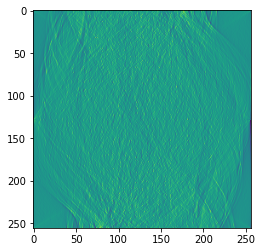

In [ ]:
test_radon = radon_data[1655]
plt.imshow(test_radon)
test_radon.shape

sample shape is (64, 256)
(256, 256)


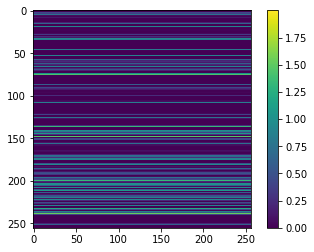

In [ ]:
# Create weird af layer
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

NUM_SAMPLES = 64
NUM_COLUMNS = 256

# np_logits = np.ones((120, 240))
# # np_logits[:, :120]=3
# logits = tf.Variable(np_logits)


logits = tf.ones((NUM_SAMPLES, NUM_COLUMNS))

logits_train = tf.Variable(initial_value=tf.ones(shape=(NUM_SAMPLES, NUM_COLUMNS)), dtype='float32' ,trainable=True)

dist = tfp.distributions.RelaxedOneHotCategorical(temperature=0.1, logits=logits_train)
sample = dist.sample()
print(f"sample shape is {sample.shape}")

k_space_vec = tf.keras.backend.sum(sample, axis=0, keepdims=False)

# print(f"k space vec shape {k_space_vec.shape}")

a=np.stack([k_space_vec]*NUM_COLUMNS, axis=1)
print(a.shape)

plt.imshow(np.stack([k_space_vec]*NUM_COLUMNS, axis=1))
plt.colorbar()

(1, 256, 256)


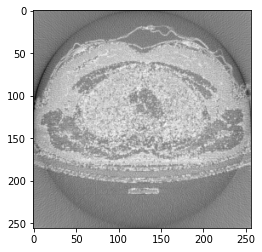

In [ ]:
weird_mult_radon = test_radon

extended_axes = np.expand_dims(weird_mult_radon, axis=0)



reco = parallel_backprojection2d(extended_axes, geometry)
print(reco.shape)
plt.imshow(reco[0], cmap=plt.cm.gray)

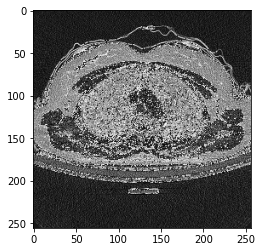

In [ ]:
plt.imshow(lungs[1655][:, :, 0], cmap=plt.cm.gray)

## Graph a sample image

3428


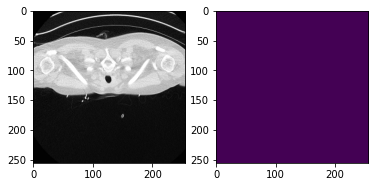

In [ ]:
import random
index = random.randint(0, len(lungs)-1)
print(index) # 10971 is a good one, 9564 is better
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

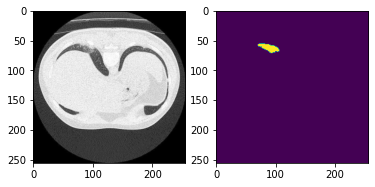

In [ ]:
index = 2700
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(lungs[index][:, :, 0], cmap=plt.cm.gray)
axs[1].imshow(infections[index][:, :, 0])

# Split Data

In [ ]:
from sklearn.model_selection import GroupKFold
group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(lungs, infections, groups)
from sklearn.utils import shuffle


train_index, test_index = group_kfold.split(lungs, infections, groups).__next__()
lung_train, lung_test = lungs[train_index], lungs[test_index]
infect_train, infect_test = infections[train_index], infections[test_index]
radon_train, radon_test = radon_data[train_index], radon_data[test_index]

# # lets also shuffle the data
lung_train, infect_train, radon_train = shuffle(lung_train, infect_train, radon_train, random_state=0)
lung_test, infect_test, radon_test = shuffle(lung_test, infect_test, radon_test, random_state=0)

print(f"leaving out {np.unique(groups[test_index])}")

# for train_index, test_index in group_kfold.split(lungs, infections, groups):
#     print(f"leaving out {np.unique(groups[test_index])}")
#     # print(len(train_index))
#     # print(len(test_index))

#     lung_train, lung_test = lungs[train_index], lungs[test_index]
#     infect_train, infect_test = infections[train_index], infections[test_index]
#     radon_train, radon_test = radon_data[train_index], radon_data[test_index]

#     # # lets also shuffle the data
#     lung_train, infect_train, radon_train = shuffle(lung_train, infect_train, radon_train, random_state=0)
#     lung_test, infect_test, radon_test = shuffle(lung_test, infect_test, radon_test, random_state=0)


leaving out [ 2 10 11 16]


In [ ]:
print(len(infect_train))
print(len(infect_test))
print(len(radon_train))

2818
702
2818


### Just pick the last split to experiment on

# Physical Models

## Radon Transform (no longer useful)

2460


Text(0.5, 1.0, 'Reconstructed Imge')

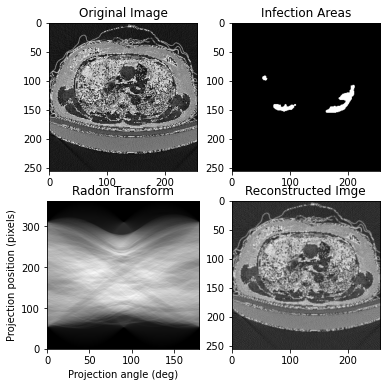

In [ ]:
from skimage.transform import iradon, radon, rescale
from skimage.util import img_as_float
import tensorflow as tf
## Take example image
index = random.randint(0, len(lungs)-1)
print(index)
image = lungs[index][:,:,0]
image = img_as_float(image)
infections_image = infections[index][:,:,0]
infections_image = img_as_float(infections_image)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
axs[0,0].imshow(image, cmap=plt.cm.gray)
axs[0,0].set_title("Original Image")
axs[0,1].imshow(infections_image, cmap=plt.cm.gray)
axs[0,1].set_title("Infection Areas")

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=False)
sinogram = sinogram / np.max(sinogram) # Not sure if this messes anything up 
                                       # but should be helfpul for radon_multiplier variable

# ML Part to Optimize
radon_multiplier = tf.Variable(initial_value=tf.ones(sinogram.shape, dtype=tf.float32), trainable=True,
                                       dtype=tf.float32,
                                       constraint=lambda t: tf.clip_by_value(t,0,2*np.pi))
# radon_multiplier = tf.Variable(initial_value=tf.random.normal(mean=0.5, stddev=0.25, shape=sinogram.shape, dtype=tf.float32),
#                                trainable=True, dtype=tf.float32,
#                                constraint=lambda t: tf.clip_by_value(t,0,1))

sinogram = sinogram * radon_multiplier       

reconstruction_fbp = iradon(sinogram, theta=theta, circle=False, filter='ramp')

axs[1,0].imshow(image, cmap=plt.cm.gray)
axs[1,0].imshow(sinogram, cmap=plt.cm.gray,
              extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
axs[1,0].set_title("Radon Transform")
axs[1,0].set_xlabel("Projection angle (deg)")
axs[1,0].set_ylabel("Projection position (pixels)")
axs[1,1].imshow(reconstruction_fbp, cmap=plt.cm.gray)
axs[1,1].set_title("Reconstructed Imge")

## Fourier Transform

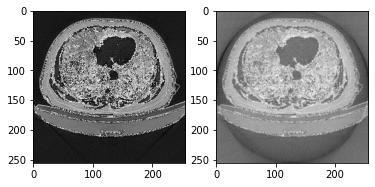

In [ ]:
## FT in physical model form
# Will do later
FT_multiplier = tf.Variable(initial_value=tf.ones([256, 256], dtype=tf.float32), trainable=True,
                                    dtype=tf.float32)

def physical_layer(x_batch):

  global logits_train
  x_batch = tf.cast(x_batch[:,:,:], dtype=tf.float32)
  # batch by h by w

  dist = tfp.distributions.RelaxedOneHotCategorical(temperature=2, logits=logits_train)
  sample = dist.sample()
  k_space_vec = tf.keras.backend.sum(sample, axis=0, keepdims=False)


  k_space_vec = tf.keras.backend.expand_dims(k_space_vec, axis=-1)

  sampled_radon = tf.math.multiply(x_batch, tf.cast(k_space_vec, dtype=tf.float32), name=None)

  inv_radon = parallel_backprojection2d(sampled_radon, geometry)



  new_image = inv_radon
  new_image = new_image[...,tf.newaxis]
  return new_image

phys_layer_test = physical_layer(radon_train[0:25,:,:])
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[4][:,:,0], cmap=plt.cm.gray)
axs[1].imshow(phys_layer_test[4][:,:,0], cmap=plt.cm.gray)

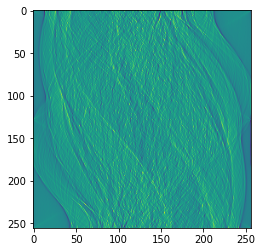

In [ ]:
plt.imshow(radon_train[4])

# Define Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D, Dropout, Flatten, Dense
import tensorflow as tf

def create_Unet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 32
    skip_list=[]

    skips=4

    for i in range(skips):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        skip_list.append(x)
        x = MaxPool2D()(x)
        x = Dropout(0.5)(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu', kernel_initializer='he_normal')(x) #7th
    x = Conv2D(start_filters*(2**3),skips, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    # up path
    for i in range(skips):
        x = UpSampling2D()(x)
        x = tf.concat([skip_list[-(i+1)], x], axis=-1)
        x = Dropout(0.5)(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    # output = Conv2D(num_classes, 1, activation='softmax')(x)
    output = Conv2D(num_classes, 1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

In [ ]:
#unet_model = create_Unet([256, 256, 1], 1)
def forward_model(x_batch):
  p_layer_out = physical_layer(x_batch)
  return unet_model(p_layer_out)

# Define Losses

In [ ]:
import numpy as np
from keras import backend as K
import tensorflow as tf

import dill


def binary_focal_loss(gamma=2., alpha=0.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def loss(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        y_true = tf.cast(y_true, tf.float32)
        # Define epsilon so that the back-propagation will not result in NaN for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        # y_pred = y_pred + epsilon
        # Clip the prediciton value
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        # Calculate p_t
        p_t = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        # Calculate alpha_t
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_t = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        # Calculate cross entropy
        cross_entropy = -K.log(p_t)
        weight = alpha_t * K.pow((1 - p_t), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.mean(K.sum(loss, axis=1))
        return loss

    return loss

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):


    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    #print("ok")
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_loss():
  def dice_p_bce(in_gt, in_pred):
    loss = 2.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
    return loss
  return dice_p_bce
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


In [ ]:
custom_adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
)

unet_model = create_Unet([256, 256, 1], 1)
unet_model.summary()
# unet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.SparseCategoricalCrossentropy()) # possibly try tf.keras.losses.BinaryCrossentropy()
#unet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
unet_model.compile(optimizer=custom_adam, loss=dice_loss(), metrics=["accuracy"]) 



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    # x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    # x = BatchNormalization(axis=3)(x)
    # x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    #x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))
    print(np.shape(inputs))

    x = stem_net(inputs)
    print(np.shape(x))


    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model


from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)
hrnet_model.summary()

#plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

(None, 256, 256, 1)
(None, 128, 128, 256)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 64) 576         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_____________________________________________

In [ ]:
# unet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.SparseCategoricalCrossentropy()) # possibly try tf.keras.losses.BinaryCrossentropy()
hrnet_model.compile(optimizer=custom_adam, loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
#unet_model.compile(optimizer=custom_adam, loss=binary_focal_loss(alpha=0.1), metrics=["accuracy"]) 

In [ ]:
unet_model.fit(lung_train, infect_train, epochs = 15, validation_data = (lung_test, infect_test))

Epoch 1/15


KeyboardInterrupt: ignored

In [ ]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):


    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    #print("ok")
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 10.0*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def decimal_IOU(y_true, y_pred, smooth=0.001):
    #print("start")
    intersection = K.sum(tf.cast(y_true, tf.float32) * y_pred, axis=[1,2])
    #print("mid")
    union = K.sum(tf.cast(y_true, tf.float32), axis=[1,2]) + K.sum(y_pred, axis=[1,2])

    return K.mean( (intersection + smooth) / (union + smooth - intersection), axis=0)

In [ ]:
logits_train = tf.Variable(initial_value=tf.random.normal(shape=(NUM_SAMPLES, NUM_COLUMNS), mean=0.0, stddev=0.1), dtype='float32' ,trainable=True)

def reset_physical_layer(trainable=True):
    global logits_train
    NUM_SAMPLES = 64
    NUM_COLUMNS = 256
    if trainable:
        #logits_train = tf.Variable(initial_value=tf.ones(shape=(NUM_SAMPLES, NUM_COLUMNS)), dtype='float32' ,trainable=True)
        logits_train = tf.Variable(initial_value=tf.random.normal(shape=(NUM_SAMPLES, NUM_COLUMNS), mean=0.0, stddev=0.1), dtype='float32' ,trainable=True)
    else:
        logits = np.zeros((NUM_SAMPLES, NUM_COLUMNS))
        logits[:, 1::2] = 1
        logits_train = tf.Variable(initial_value=logits, dtype='float32' ,trainable=False)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((radon_train, infect_train)).shuffle(10000).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((radon_test, infect_test)).batch(16)

FT_multiplier = tf.Variable(initial_value=tf.ones([256, 256], dtype=tf.float32), trainable=True,
                                    dtype=tf.float32)

unet_model = create_Unet([256, 256, 1], 1)

## Reset multiplier


## NEW TF GRADIENT TAPE
#loss_object = tf.keras.losses.BinaryCrossentropy()



loss_object=dice_p_bce


reset_physical_layer(True)



optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
# ...
@tf.function
def train_step(images, labels):
  with tf.GradientTape(persistent=True) as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = forward_model(images)
    loss = loss_object(labels, predictions)
  training_variables = [logits_train] + unet_model.trainable_variables
  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return predictions

@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).

  predictions = forward_model(images)
  t_loss = loss_object(labels, predictions)

  ## If you add a print statement here, for som reason, only prints at first epoch

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return predictions

EPOCHS = 40 # Change back to 25

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
      predictions = train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_predictions = test_step(test_images, test_labels)
    if epoch == EPOCHS:
      print(test_predictions)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 1.7158825397491455, Accuracy: 98.54501342773438, Test Loss: 0.548218846321106, Test Accuracy: 98.98548889160156
Epoch 2, Loss: 0.3611949384212494, Accuracy: 99.161865234375, Test Loss: 0.9252192378044128, Test Accuracy: 99.12952423095703
Epoch 3, Loss: 0.36951160430908203, Accuracy: 99.21868133544922, Test Loss: 0.4809034764766693, Test Accuracy: 99.10107421875
Epoch 4, Loss: 0.29442089796066284, Accuracy: 99.21990203857422, Test Loss: 0.8271217346191406, Test Accuracy: 99.12957763671875
Epoch 5, Loss: 0.20412251353263855, Accuracy: 99.17167663574219, Test Loss: 0.42309069633483887, Test Accuracy: 99.1099853515625
Epoch 6, Loss: -0.02483374997973442, Accuracy: 99.15675354003906, Test Loss: 0.4252434968948364, Test Accuracy: 99.00682830810547
Epoch 7, Loss: -0.20530158281326294, Accuracy: 99.1727066040039, Test Loss: 0.6737701296806335, Test Accuracy: 99.08702850341797
Epoch 8, Loss: -0.3760528564453125, Accuracy: 99.31990051269531, Test Loss: 0.5729039907455444, Test Acc

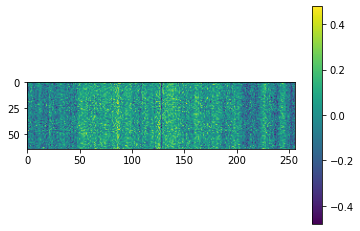

In [ ]:
plt.imshow(logits_train.value())
plt.colorbar()

(256,)
[-16.156366    -3.1899817   -2.248555    -0.8605372   -1.1231097
  -3.5462399   -6.018521    -6.127543    -3.3361886   -4.7899523
  -3.5254555    1.1933956    0.8051873   -3.8683732   -4.075081
  -5.3384447   -5.9983754   -4.749347    -4.022856    -8.385167
  -5.7246776    2.9808521    0.2542791   -1.6553102   -1.9545542
  -3.0119817   -6.348865    -4.7751513   -5.5709367   -3.2117815
  -4.278726    -0.15458904   1.9358691   -1.5900866   -0.5969265
   1.8441656   -4.2042484   -3.1633604   -0.91246665  -4.419337
  -2.3875356   -7.640276    -2.624755    -1.7008543   -3.7180276
  -3.895442    -2.4028614   -4.985862     1.6097147    3.3031027
   6.9383073    4.877747     7.9397893    6.4864483    6.7683644
   6.202085     7.356456     5.1531796    3.118393     3.1934812
   4.679117     4.0285463    4.2955327    3.4949036    7.829662
   5.170309     3.6476676    3.0797467    1.4079618    2.9739985
   6.6302457    3.2133913    5.5261474    4.3022723    9.128454
   6.9454923    3.54021

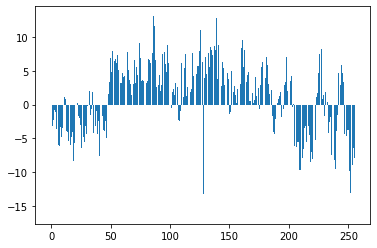

In [ ]:
a = np.sum(logits_train.value(), axis=0)
print(a.shape)
plt.bar(np.arange(0, 256), np.sum(logits_train.value(), axis=0))
print(a)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

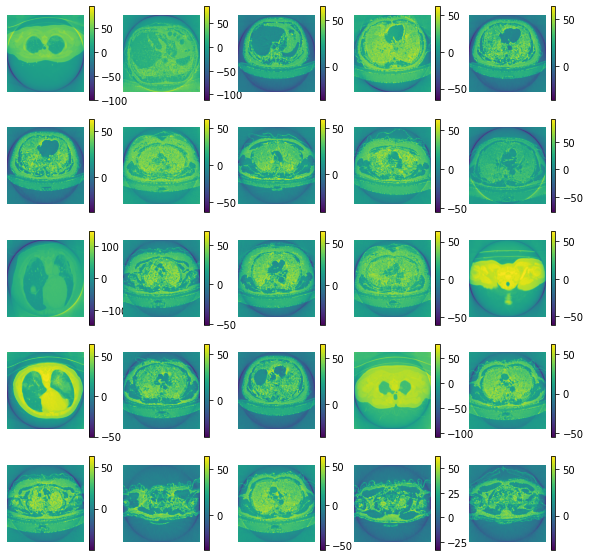

In [ ]:
plt.figure()
# plt.imshow(abs(FT_multiplier))
# plt.colorbar()

def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i, :, :, 0])
        plt.colorbar()
        plt.axis('off')
    plt.show()

plt.figure()
plot_examples(physical_layer(radon_train[:25]))

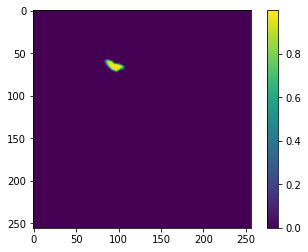

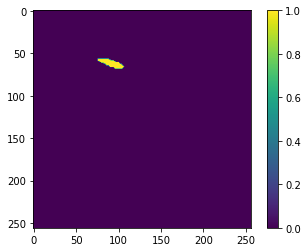

In [ ]:
# Very rudimentary - you can see that it's actually working with TF graident tape, though
plt.imshow(test_predictions[1,:,:,0])
plt.colorbar()
plt.figure()
plt.imshow(test_labels[1,:,:,0])
plt.colorbar()

# Fix Layer

(256,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


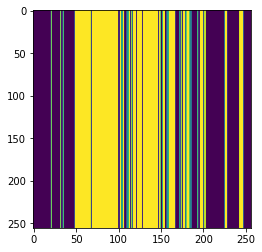

In [ ]:
# NEW 
def generate_best_physical_layer(desired_cols):
    global logits_train
    NUM_COLUMNS = 256
    # #visualize the most likely selection

    sum_logits = tf.keras.backend.sum(logits_train.numpy(), axis=0, keepdims=False)

    most_likely = np.argsort(-sum_logits)[:desired_cols]

    k_space_vec = np.zeros(256)
    k_space_vec[most_likely]=1
    print(k_space_vec.shape)
    return k_space_vec
  
k_space_vec_unet = generate_best_physical_layer(128)
print(k_space_vec_unet)
plt.imshow(np.stack([k_space_vec_unet]*256, axis=0))

Text(0.5, 1.0, 'Post-transform')

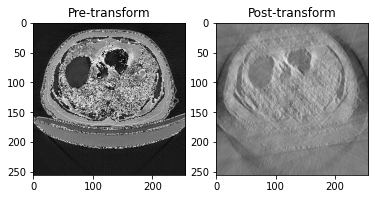

In [ ]:

def physical_layer_fixed(x_batch, k_space_vec):

    x_batch = tf.cast(x_batch[:,:,:], dtype=tf.float32)

    k_space_vec = tf.keras.backend.expand_dims(k_space_vec, axis=-1)

    sampled_radon = tf.math.multiply(x_batch, tf.cast(k_space_vec, dtype=tf.float32), name=None)

    inv_radon = parallel_backprojection2d(sampled_radon, geometry)

    new_image = inv_radon
    new_image = new_image[...,tf.newaxis]
    return new_image


    new_image = tf.signal.ifft2d(tf.signal.fftshift(sampled_four))
    new_image = abs(new_image)
    new_image = new_image[...,tf.newaxis]
    return new_image



phys_layer_test = physical_layer_fixed(radon_train[0:24,:,:], k_space_vec_unet)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 6))
axs[0].imshow(lung_train[17][:,:,0], cmap=plt.cm.gray)
axs[0].set_title("Pre-transform")
axs[1].imshow(phys_layer_test[17][:,:,0], cmap=plt.cm.gray)
axs[1].set_title("Post-transform")

# Visualize Test Results

In [ ]:
import random
predicted = forward_model(radon_test[0:120])
fig = plt.figure(figsize = (18,15))

# force it to pick a covid example
number = random.randint(0, 200)
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, 200)

print(radon_test.shape)
a = physical_layer(radon_test[number:number+2])
print(a.shape)

plt.subplot(1,3,1)
plt.imshow(a[0, :, :, 0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,3,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0])
plt.imshow(predicted[number][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')
plt.colorbar()

AttributeError: ignored

# Confusion Matrix Code

In [ ]:
import sklearn
def get_confusion_matrix_elements(groundtruth_image, predicted_image, threshold):

    threshold_image = predicted_image>threshold


    groundtruth_list = groundtruth_image.ravel()
    predicted_list = threshold_image.ravel()

    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
    """
    all_sum = len(groundtruth_list)

    if np.sum(groundtruth_list)==all_sum and np.sum(predicted_list)==all_sum:
        tn, fp, fn, tp = 0, 0, 0, np.float64(len(groundtruth_list))

    elif np.sum(groundtruth_list)==0 and np.sum(predicted_list)==0:
        tn, fp, fn, tp = np.float64(len(groundtruth_list)), 0, 0, 0

    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth_list, predicted_list).ravel()
        tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp


def batch_confusion_matrix_elements(infection_masks, predicted_masks, threshold):
    results = []

    for i in tqdm_notebook(range(len(predicted))):
        results.append(get_confusion_matrix_elements(infection_masks[i], predicted_masks[i], threshold))
    
    return np.sum(results, axis=0)


def confusion_matrix_plot_hacky(tn, fp, fn, tp):
    fake_label=np.zeros(int(tn))
    fake_predict = np.zeros(int(tn))

    fake_label = np.append(fake_label, np.zeros(int(fp)))
    fake_predict = np.append(fake_predict, np.ones(int(fp)))

    fake_label = np.append(fake_label, np.ones(int(fn)))
    fake_predict = np.append(fake_predict, np.zeros(int(fn)))

    fake_label = np.append(fake_label, np.ones(int(tp)))
    fake_predict = np.append(fake_predict, np.ones(int(tp)))

    print("Printing Classification Report")

    from sklearn.metrics import classification_report, confusion_matrix
    target_names = ['No Covid', 'Covid']
    print(classification_report(fake_label, fake_predict, target_names=target_names))


    print("Printing Confusio Martrix")

    import seaborn as sns

    cm = confusion_matrix(fake_label, fake_predict)

    print(cm)
    ax= plt.subplot(1,1,1)
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['No Covid', 'Infected']); ax.yaxis.set_ticklabels(['No Covid', 'Infected']);

(65520.0, 0.0, 16.0, 0.0)


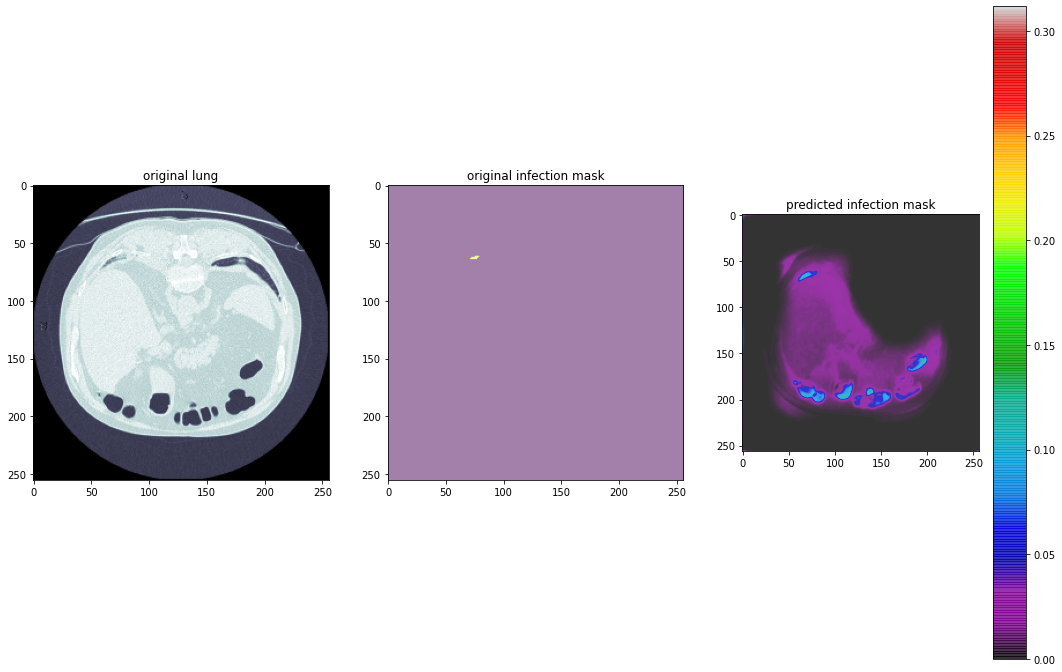

In [ ]:
predicted = unet_model.predict(lung_test)
fig = plt.figure(figsize = (18,12))


# force it to pick a covid example
number = random.randint(0, len(lung_test))
while np.sum(infect_test[number][...,0])==0:
    number = random.randint(0, len(lung_test))

plt.subplot(1,3,1)
plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
#plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(infect_test[number][...,0],alpha = 0.5)
plt.title('original infection mask')

plt.subplot(1,3,3)
# plt.imshow(lung_test[number][...,0], cmap = 'bone')
plt.imshow(predicted[number][...,0],alpha = 0.8,cmap = "nipy_spectral")
plt.title('predicted infection mask')
plt.colorbar()

print(get_confusion_matrix_elements(infect_test[number], predicted[number], threshold = 0.5))


## Make sure to change the Threshold value to see how it changes the results


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Printing Classification Report
              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00  46301360
       Covid       0.52      0.02      0.04    229200

    accuracy                           1.00  46530560
   macro avg       0.76      0.51      0.52  46530560
weighted avg       0.99      1.00      0.99  46530560

Printing Confusio Martrix
[[46296802     4558]
 [  224355     4845]]


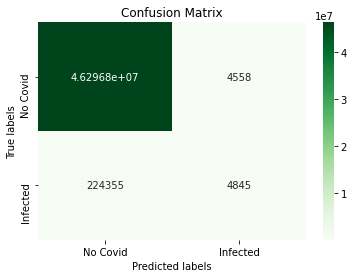

In [ ]:
tn, fp, fn, tp = batch_confusion_matrix_elements(infect_test, predicted, threshold=0.5)

confusion_matrix_plot_hacky(tn, fp, fn, tp)

In [ ]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras.layers import UpSampling2D, add, concatenate


def conv3x3(x, out_filters, strides=(1, 1)):
    x = Conv2D(out_filters, 3, padding='same', strides=strides, use_bias=False, kernel_initializer='he_normal')(x)
    return x


def basic_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    x = conv3x3(input, out_filters, strides)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = conv3x3(x, out_filters)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def bottleneck_Block(input, out_filters, strides=(1, 1), with_conv_shortcut=False):
    expansion = 4
    de_filters = int(out_filters / expansion)

    x = Conv2D(de_filters, 1, use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(de_filters, 3, strides=strides, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Conv2D(out_filters, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)

    if with_conv_shortcut:
        residual = Conv2D(out_filters, 1, strides=strides, use_bias=False, kernel_initializer='he_normal')(input)
        residual = BatchNormalization(axis=3)(residual)
        x = add([x, residual])
    else:
        x = add([x, input])

    x = Activation('relu')(x)
    return x


def stem_net(input):
    x = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = bottleneck_Block(x, 256, with_conv_shortcut=True)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)
    x = bottleneck_Block(x, 256, with_conv_shortcut=False)

    return x


def transition_layer1(x, out_filters_list=[32, 64]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x)
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    return [x0, x1]


def make_branch1_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch1_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer1(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0 = add([x0_0, x0_1])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1 = add([x1_0, x1_1])
    return [x0, x1]


def transition_layer2(x, out_filters_list=[32, 64, 128]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    return [x0, x1, x2]


def make_branch2_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch2_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer2(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0 = add([x0_0, x0_1, x0_2])

    x1_0 = Conv2D(64, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x1_0 = BatchNormalization(axis=3)(x1_0)
    x1_1 = x[1]
    x1_2 = Conv2D(64, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x1_2 = BatchNormalization(axis=3)(x1_2)
    x1_2 = UpSampling2D(size=(2, 2))(x1_2)
    x1 = add([x1_0, x1_1, x1_2])

    x2_0 = Conv2D(32, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_0 = Activation('relu')(x2_0)
    x2_0 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x2_0)
    x2_0 = BatchNormalization(axis=3)(x2_0)
    x2_1 = Conv2D(128, 3, strides=(2, 2), padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x2_1 = BatchNormalization(axis=3)(x2_1)
    x2_2 = x[2]
    x2 = add([x2_0, x2_1, x2_2])
    return [x0, x1, x2]


def transition_layer3(x, out_filters_list=[32, 64, 128, 256]):
    x0 = Conv2D(out_filters_list[0], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[0])
    x0 = BatchNormalization(axis=3)(x0)
    x0 = Activation('relu')(x0)

    x1 = Conv2D(out_filters_list[1], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[1])
    x1 = BatchNormalization(axis=3)(x1)
    x1 = Activation('relu')(x1)

    x2 = Conv2D(out_filters_list[2], 3, padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x2 = BatchNormalization(axis=3)(x2)
    x2 = Activation('relu')(x2)

    x3 = Conv2D(out_filters_list[3], 3, strides=(2, 2),
                padding='same', use_bias=False, kernel_initializer='he_normal')(x[2])
    x3 = BatchNormalization(axis=3)(x3)
    x3 = Activation('relu')(x3)

    return [x0, x1, x2, x3]


def make_branch3_0(x, out_filters=32):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_1(x, out_filters=64):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_2(x, out_filters=128):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def make_branch3_3(x, out_filters=256):
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    x = basic_Block(x, out_filters, with_conv_shortcut=False)
    return x


def fuse_layer3(x):
    x0_0 = x[0]
    x0_1 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[1])
    x0_1 = BatchNormalization(axis=3)(x0_1)
    x0_1 = UpSampling2D(size=(2, 2))(x0_1)
    x0_2 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[2])
    x0_2 = BatchNormalization(axis=3)(x0_2)
    x0_2 = UpSampling2D(size=(4, 4))(x0_2)
    x0_3 = Conv2D(32, 1, use_bias=False, kernel_initializer='he_normal')(x[3])
    x0_3 = BatchNormalization(axis=3)(x0_3)
    x0_3 = UpSampling2D(size=(8, 8))(x0_3)
    x0 = concatenate([x0_0, x0_1, x0_2, x0_3], axis=-1)
    return x0


def final_layer(x, classes=1):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(classes, 1, use_bias=False, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('sigmoid', name='Classification')(x)
    return x


def seg_hrnet(batch_size, height, width, channel, classes):
    inputs = Input(batch_shape=(batch_size,) + (height, width, channel))
    print(np.shape(inputs))

    x = stem_net(inputs)
    print(np.shape(x))


    x = transition_layer1(x)
    x0 = make_branch1_0(x[0])
    x1 = make_branch1_1(x[1])
    x = fuse_layer1([x0, x1])

    x = transition_layer2(x)
    x0 = make_branch2_0(x[0])
    x1 = make_branch2_1(x[1])
    x2 = make_branch2_2(x[2])
    x = fuse_layer2([x0, x1, x2])

    x = transition_layer3(x)
    x0 = make_branch3_0(x[0])
    x1 = make_branch3_1(x[1])
    x2 = make_branch3_2(x[2])
    x3 = make_branch3_3(x[3])
    x = fuse_layer3([x0, x1, x2, x3])

    out = final_layer(x, classes=classes)

    model = Model(inputs=inputs, outputs=out)

    return model

In [ ]:
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)
hrnet_model.summary()

#plot_model(model, to_file='seg_hrnet.png', show_shapes=True)

(None, 256, 256, 1)
(None, 128, 128, 256)
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 64) 576         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 128, 128, 64) 256         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 128, 128, 64) 0           batch_normalization_54[0][0]     
_____________________________________________

In [ ]:
# train_ds = tf.data.Dataset.from_tensor_slices((lung_train, infect_train)).shuffle(10000).batch(16)
# test_ds = tf.data.Dataset.from_tensor_slices((lung_test, infect_test)).batch(16)
optimize_physical_layer = True #@param {type:"boolean"}

# hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)

global logits_train

reset_layer = True #@param {type:"boolean"}
if reset_layer:
    reset_physical_layer(optimize_physical_layer)

# Make sure to reset "unet_FT_multiplier" to whatever pre-initialized variable you are testing
def forward_model(x_batch):
  p_layer_out = physical_layer(x_batch)
  return hrnet_model(p_layer_out)


loss_object = binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
@tf.function
def train_step(images, labels):
  with tf.GradientTape(persistent=True) as tape:
    predictions = forward_model(images)
    loss = loss_object(labels, predictions)


  if optimize_physical_layer:
    training_variables = [logits_train] + hrnet_model.trainable_variables
  else:
    training_variables = hrnet_model.trainable_variables

  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = forward_model(images)
  t_loss = loss_object(labels, predictions)
  ## If you add a print statement here, for some reason, only prints at first epoch
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

EPOCHS = 15 # Change back to 25

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    # NEED TO FIGURE OUT HOW TO RETURN METRICS BASED ON ALL OF TRAIN_DS
    # NOT JUST LAST ITERATION
    train_dice_coef, train_decimal_iou = train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_dice_coef, test_decimal_iou = test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'loss: {train_loss.result()}, '
    f'dice_coef: {train_dice_coef[0]}, '
    f'decimal_IOU: {train_decimal_iou[0]}, '
    f'accuracy: {train_accuracy.result() * 100}, '
    f'test_loss: {test_loss.result()}, '
    f'test_dice_coef: {test_dice_coef[0]}, '
    f'test_decimal_iou: {test_decimal_iou[0]}, '
    f'test_accuracy: {test_accuracy.result() * 100}'
  )

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((radon_train, infect_train)).shuffle(10000).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((radon_test, infect_test)).batch(16)

optimize_physical_layer = True #@param {type:"boolean"}

# hrnet_model = seg_hrnet(batch_size=None, height=256, width=256, channel=1, classes=1)

global logits_train

reset_layer = False #@param {type:"boolean"}
if reset_layer:
    reset_physical_layer(optimize_physical_layer)

# Make sure to reset "unet_FT_multiplier" to whatever pre-initialized variable you are testing
def forward_model(x_batch):
  p_layer_out = physical_layer(x_batch)
  return hrnet_model(p_layer_out)


loss_object = binary_crossentropy
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy', threshold=0.5)

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy', threshold=0.5)

# train loop
@tf.function
def train_step(images, labels):
  with tf.GradientTape(persistent=True) as tape:
    predictions = forward_model(images)
    loss = loss_object(labels, predictions)


  if optimize_physical_layer:
    training_variables = [logits_train] + hrnet_model.trainable_variables
  else:
    training_variables = hrnet_model.trainable_variables

  gradients = tape.gradient(loss, training_variables)
  optimizer.apply_gradients(zip(gradients, training_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

@tf.function
def test_step(images, labels):
  predictions = forward_model(images)
  t_loss = loss_object(labels, predictions)
  ## If you add a print statement here, for some reason, only prints at first epoch
  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return dice_coef(labels, predictions), decimal_IOU(labels, predictions)

EPOCHS = 20 # Change back to 25

for epoch in range(EPOCHS):
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    # NEED TO FIGURE OUT HOW TO RETURN METRICS BASED ON ALL OF TRAIN_DS
    # NOT JUST LAST ITERATION
    train_dice_coef, train_decimal_iou = train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_dice_coef, test_decimal_iou = test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'loss: {train_loss.result()}, '
    f'dice_coef: {train_dice_coef[0]}, '
    f'decimal_IOU: {train_decimal_iou[0]}, '
    f'accuracy: {train_accuracy.result() * 100}, '
    f'test_loss: {test_loss.result()}, '
    f'test_dice_coef: {test_dice_coef[0]}, '
    f'test_decimal_iou: {test_decimal_iou[0]}, '
    f'test_accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, loss: 0.04514973983168602, dice_coef: 0.024723771959543228, decimal_IOU: 0.01205856166779995, accuracy: 99.16901397705078, test_loss: 0.028701534494757652, test_dice_coef: 0.01365500409156084, test_decimal_iou: 0.00621192529797554, test_accuracy: 99.50743865966797
Epoch 2, loss: 0.035861704498529434, dice_coef: 0.031898193061351776, decimal_IOU: 0.015870289877057076, accuracy: 99.16895294189453, test_loss: 0.02932526171207428, test_dice_coef: 0.013319662772119045, test_decimal_iou: 0.006102161481976509, test_accuracy: 99.50743865966797
Epoch 3, loss: 0.03567986935377121, dice_coef: 0.041619617491960526, decimal_IOU: 0.02122301235795021, accuracy: 99.16897583007812, test_loss: 0.02995135635137558, test_dice_coef: 0.01374741643667221, test_decimal_iou: 0.006371410097926855, test_accuracy: 99.50743865966797
Epoch 4, loss: 0.03525663912296295, dice_coef: 0.026001352816820145, decimal_IOU: 0.012556783854961395, accuracy: 99.16891479492188, test_loss: 0.028274504467844963, test_dice

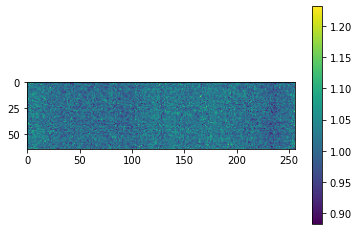

In [ ]:
plt.imshow(np.abs(logits_train.value()))
plt.colorbar()

(256,)
[63.9726   65.70287  65.98583  65.84344  65.255554 66.39821  66.11219
 65.86778  65.94334  66.348564 66.03778  65.56666  65.67718  65.31006
 64.919495 65.86248  65.7907   65.02181  64.79014  64.95874  64.6854
 65.01357  64.94472  64.88636  64.72808  65.16445  64.97368  64.65779
 64.81697  64.55322  64.53639  64.737114 63.97633  64.009476 64.25694
 64.48212  64.78031  64.58905  64.84863  64.96386  64.54091  64.905556
 64.54347  64.665794 64.163956 64.38708  64.397285 64.3295   64.94279
 64.46568  64.37576  64.82046  64.72783  64.4464   64.3332   64.27554
 64.011345 64.60888  64.454384 64.635155 64.15415  64.29757  65.04941
 64.04892  64.48236  64.90468  64.60921  64.26946  64.54849  64.53515
 64.672134 64.62527  64.291    64.25844  64.15076  64.93837  64.00822
 63.855293 65.290184 64.852615 65.22534  64.81241  64.5476   64.431625
 65.1819   64.41723  63.904327 64.18285  64.58643  64.42145  64.31674
 63.57895  64.40592  64.77346  64.54514  63.775555 64.346    64.148766
 64.46117  

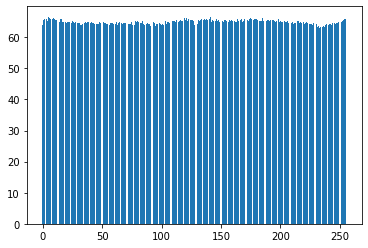

In [ ]:
a = np.sum(logits_train.value(), axis=0)
print(a.shape)
plt.bar(np.arange(0, 256), np.sum(logits_train.value(), axis=0))
print(a)

In [ ]:
def visualize_physical_layer(top_col):
    global logits_train
    NUM_COLUMNS = 256
    # #visualize the most likely selection

    sum_logits = tf.keras.backend.sum(logits_train.numpy(), axis=0, keepdims=False)

    most_likely = np.argsort(-sum_logits)[:top_col]

    k_space_vec = np.zeros(256)
    k_space_vec[most_likely]=1

    plt.figure(figsize=(10,10))
    plt.imshow(np.stack([k_space_vec]*NUM_COLUMNS, axis=0))
    plt.colorbar()


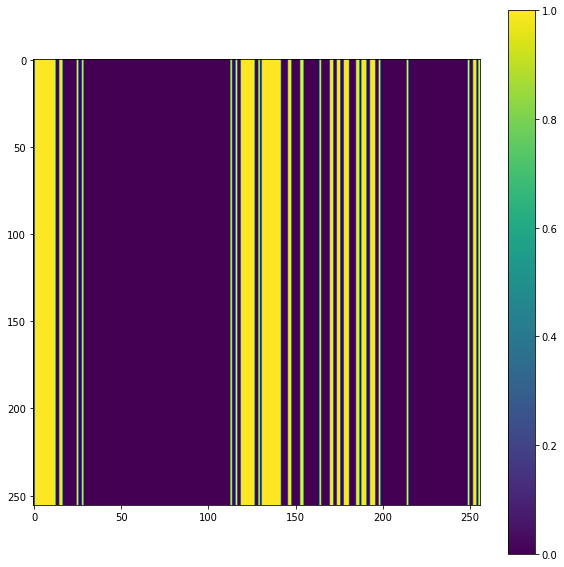

In [ ]:
visualize_physical_layer(64)

Recall = $\frac{TP}{TP+FN}$

Precision = $\frac{TP}{TP+FP}$

IOU = $\frac{TP}{TP+FP+FN}$